Notebook for implementing DMRG tree structure optimization on tensor network level. 

In [1]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")



Trivertex_classical_ising_partition_function (generic function with 2 methods)

In [2]:
function replace_index(tensor, replace_inds, new_inds)
    
    mapping = Dict(zip(replace_inds, new_inds))
    #display(mapping)
    current_inds = inds(tensor)
    ids = []
    for id in current_inds
        if id in replace_inds
            push!(ids, mapping[id])
        else
            push!(ids, id)
        end
    end
    new_tensor = Tenet.Tensor(tensor.data, [ids...])
    return new_tensor
end


function extract_partial_tn_loop(TN, cycle, printing = false)
    tensors_in_loop = collect(Set([tensor for id in cycle for tensor in Tenet.select(TN, Symbol(id))])) #correct orderding of variable definitions
    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    #drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
    #display(drawing1)
    index_cut = Symbol(cycle[1])
    edge_tensors = Tenet.select(TN, index_cut)

    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Spectral(), edge_color=:grey80)
        display(drawing1)
    end

    
    return current_tn
end



function generate_unique_symbols(existing_indices::Vector{Symbol}, l::Int, min_value::Int=1, max_value::Int=200)

    """
    Function which generates a list of new symbols for index replacing capability
    """

    existing_integers = [parse(Int, string(id)) for id in existing_indices]
    potential_length = round(Int, 4*l)  # Generate at least twice the desired length
    new_symbols = []
    for i in 1:potential_length
        number = rand(min_value:max_value)
        if !in(number, existing_integers)
            if !in(number, new_symbols)
                push!(new_symbols, number)
            end
        end
        if length(new_symbols) == l
            new_symbols = [Symbol(new) for new in new_symbols]
            break
        end
    end


  
    return new_symbols
  
end

function collect_tensors_along_loop(loop_tn, index_cycle, edge_to_cut)

    """
    Funtion whcih sequentially walks along the loop and selects the relevant tensors
    """

    connectedtensors = Tenet.select(loop_tn, Symbol(edge_to_cut))
    firstsymbol = Symbol(index_cycle[1])
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end
    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != parse(Int, string(connecting_id[1])), index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
end



collect_tensors_along_loop (generic function with 1 method)

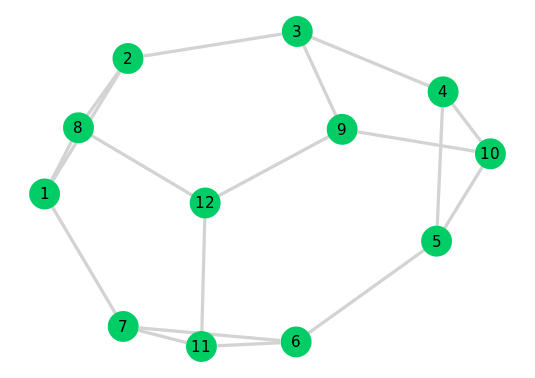

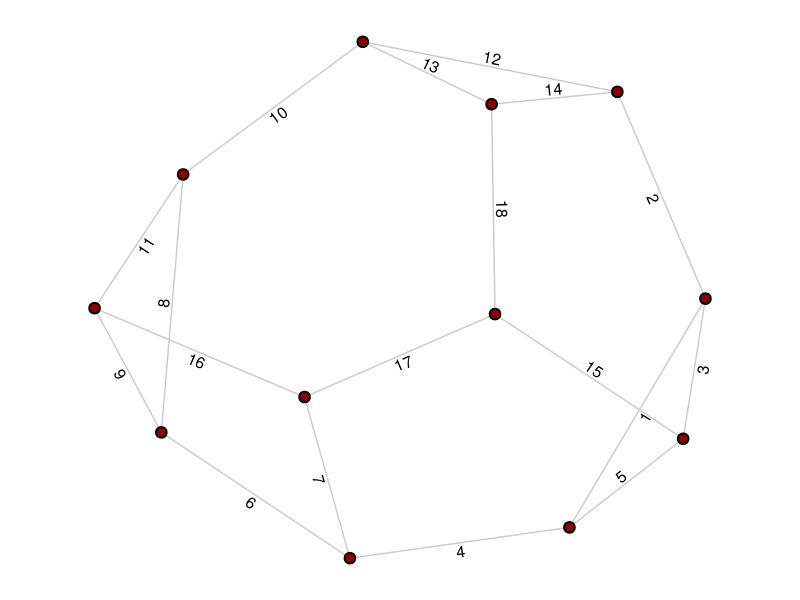

CairoMakie.Screen{IMAGE}


In [3]:
# Implement a frucht graph TN, try to selected a cycle to transform into DMRG approachable tree

dimension = 3
G = Graphs.smallgraph(:frucht)
tn1 = fill_with_random(G, dimension, true, true)
locs_x =     [4, 4, -5, -2, 0, 0, 2, 0, -3, -1, -6, -4]
locs_y = -1*[-2, 1, -2, -1, 0, -2, 0, 3, 3, 1, 1, 0]
g, tensordict, edgesdict, fully_weighted_edge_list, edge_index_map = extract_graph_representation(tn1, false)

drawing1 = Makie.plot(tn1, node_color=[:darkred for i in 1:length(tensors(tn1))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)

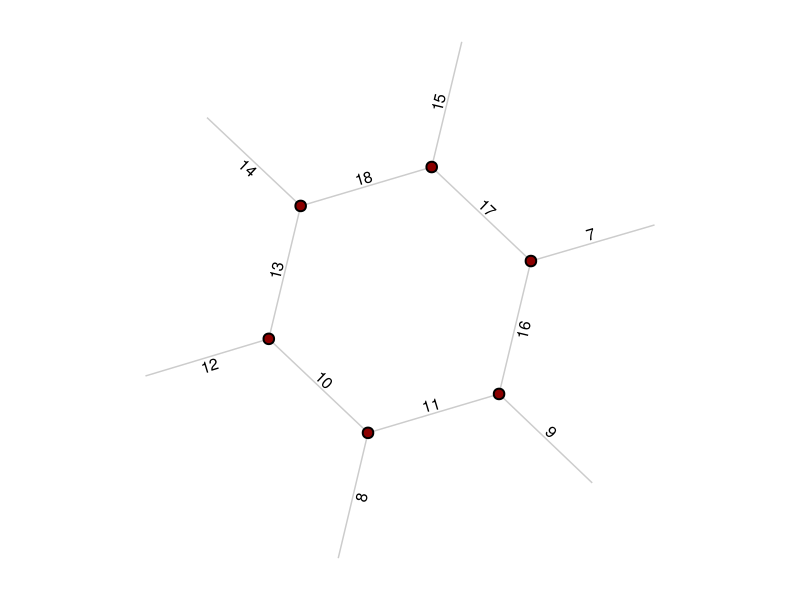

index_cycle = [10, 13, 18, 17, 16, 11]
mps cycle = [11, 10, 13, 18, 17]
------------------ Indices ordered along loop -------------------------
________________________Working on step = 1_______________________________________
 Tensor 1  => [Symbol("9"), Symbol("11"), Symbol("16")]with sizes[3, 3, 3]
 propagating_iso_index = 11
[Symbol("11_"), Symbol("16_"), :v1]
________________________Working on step = 2_______________________________________
 Tensor 2  => [Symbol("8"), Symbol("10"), Symbol("11")]with sizes[3, 3, 3]
 propagating_iso_index = 11
newt = [Symbol("8"), Symbol("10__"), Symbol("11")]
oldiso =[:v1, Symbol("11"), Symbol("16")]
new_split =[:v1, Symbol("11"), Symbol("16__")]
grouplegs = [Symbol("16"), Symbol("10")]grouplegs_new = [Symbol("16__"), Symbol("10__")]
[Symbol("16__"), Symbol("10__"), :v2]
________________________Working on step = 3_______________________________________
 Tensor 3  => [Symbol("10"), Symbol("12"), Symbol("13")]with sizes[3, 3, 3]
 propagating_iso_index

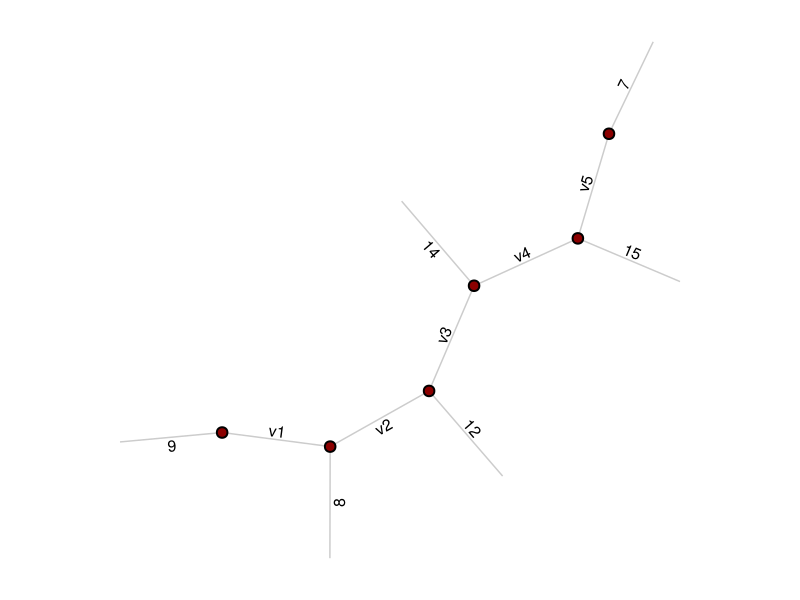

In [9]:
function RandomUnitaryMatrix(N::Int)
    x = (rand(N,N) + rand(N,N)*im) / sqrt(2)
    f = qr(x)
    diagR = sign.(real(diag(f.R)))
    diagR[diagR.==0] .= 1
    diagRm = diagm(diagR)
    u = f.Q * diagRm
    return u
end




index_cycle = [10, 13, 18, 17, 16, 11]
index_to_cut = 16
printing = true
original_network = extract_partial_tn_loop(tn1, index_cycle)

drawing1 = Makie.plot(original_network, node_color=[:darkred for i in 1:length(tensors(original_network))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)


println("index_cycle = ", index_cycle)
idx = findfirst(isequal(index_to_cut), index_cycle)
mps_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
println("mps cycle = ", mps_cycle)
ordered_along_loop = collect_tensors_along_loop(original_network, deepcopy(mps_cycle), index_to_cut)

println("------------------ Indices ordered along loop -------------------------")


new_tn_tensors = []
global contract_list = []
global loop_size
global propagating_iso_index
global propagating_iso_split 
global loop_index_propagation

additive = "________________________________________________________________________"



"""
Walk along the loop and make the necessary alterations at each step
"""
new_virtual_inds = [Symbol("v$i") for i in 1:10]
collect_virtual = []
contracted_first = []

for (i, tensor) in enumerate(ordered_along_loop)
    println("________________________Working on step = $i"*"_______________________________________")
    println(" Tensor $i  => ", inds(tensor), "with sizes", [size(tensor, id) for id in inds(tensor)])

    # cases on the edges of the tensor network loop are treated seperately
    if i == 1
        global loop_size = [size(tensor, id) for id in inds(tensor) if id == Symbol(index_to_cut)][1]
        global loop_index_propagation = Symbol(index_to_cut)
        current_inds = inds(tensor)
        dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
        grouplegs = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
        grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
        new_t = replace_index(tensor, grouplegs, grouplegs_new)
        tensor_id = setdiff(inds(tensor), [Symbol(index_to_cut), dangling_leg[1]])[1]
        global propagating_iso_index = tensor_id
        push!(contracted_first, propagating_iso_index)
        println(" propagating_iso_index = ", propagating_iso_index)
        tensor_size = size(tensor, tensor_id)
        grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])
        push!(collect_virtual, new_virtual_inds[i])
        global propagating_iso_split = splitting
        push!(new_tn_tensors, new_t)
        push!(new_tn_tensors, grouping)

        continue
    end


    # general bulk case
    if 1 < i < length(ordered_along_loop)
        println(" propagating_iso_index = ", propagating_iso_index)
        current_inds = inds(tensor)
        dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
        next_group_leg = setdiff(inds(tensor), [propagating_iso_index, dangling_leg[1]])[1]
        tensor_size = size(tensor, next_group_leg)
        
        grouplegs = [loop_index_propagation, next_group_leg]
        grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
        push!(contracted_first, grouplegs_new[2])

        new_t = replace_index(tensor, grouplegs, grouplegs_new)
        println("newt = ", inds(new_t))
        println("oldiso =", inds(propagating_iso_split))
        new_split = replace_index(propagating_iso_split, grouplegs, grouplegs_new)
        println("new_split =", inds(new_split))

        println("grouplegs = ", grouplegs, "grouplegs_new = ", grouplegs_new)
        grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])
        push!(new_tn_tensors, new_split)
        push!(new_tn_tensors, new_t)
        push!(new_tn_tensors, grouping)
        global propagating_iso_split = splitting
        global propagating_iso_index = next_group_leg

        push!(collect_virtual, new_virtual_inds[i])

        continue
    end

    if i == length(ordered_along_loop)
        push!(new_tn_tensors, propagating_iso_split)
        push!(new_tn_tensors, tensor)
    end

end

println("first do these = ", contracted_first)
mps_network = Tenet.TensorNetwork(new_tn_tensors)

contraction_list = inds(mps_network, :inner)

contract_list = vcat(contracted_first, setdiff(contraction_list, collect_virtual))
println(contract_list)
for id in contract_list
    if id ∈ inds(mps_network)
        contraction_step(mps_network, id)
    end
end

drawing1 = Makie.plot(mps_network, node_color=[:darkred for i in 1:length(tensors(mps_network))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)


T_loop = Tenet.contract(original_network)
T_tree = Tenet.contract(mps_network)


overlap_looploop = abs((Tenet.contract(adjoint(T_loop), T_loop))[1])
overlap_treetree = abs((Tenet.contract(adjoint(T_tree), T_tree))[1])
overlap_full = abs((Tenet.contract(adjoint(T_tree), T_loop))[1])

println(" ---------------- FIDELITY ANALYSIS ------------ ")
println("< Loop - state | Loop - state > = ", overlap_looploop)
println("< MPS - state | MPS - state > = ", overlap_treetree)
println("< Loop - state| Tree - state > = ", overlap_full)
println("|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))




In [5]:

function random_unitary_tensor_and_random_unitary_inverse(size1, size2, inserted_indices, new_inds, virtual_symbol)
    groupsize = size1*size2
    Q = Matrix{ComplexF64}(I, groupsize, groupsize)
    group_inds = [id for id in [inserted_indices..., virtual_symbol]]
    println((group_inds))
    grouping = Tenet.Tensor(reshape(Q, (size1,size2,groupsize)), group_inds)
    splitting = Tenet.Tensor(reshape(inv(Q), (groupsize,size1, size2)), [virtual_symbol, new_inds...])
    id = Tenet.contract(grouping, splitting)
    #println("Reshaped data is a correct Q^dag*Q = I ? ==> ", isapprox(reshape(id.data, (groupsize,groupsize)), I))
    return grouping, splitting
end


function Tenet_loop_2_Tenet_MPS(loop, index_cycle, index_to_cut, printing = false)
    global new_tn_tensors = []
    global contract_list = []
    global loop_size
    global propagating_iso_index
    global propagating_iso_split 
    global loop_index_propagation
    
    idx = findfirst(isequal(index_to_cut), index_cycle)
    mps_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
    ordered_along_loop = collect_tensors_along_loop(original_network, deepcopy(mps_cycle), index_to_cut)

    """
    Walk along the loop and make the necessary alterations at each step
    """
    new_virtual_inds = [Symbol("v$i") for i in 1:100]
    collect_virtual = []
    
    for (i, tensor) in enumerate(ordered_along_loop)
        if printing == true
            println("________________________Working on step = $i"*"_______________________________________")
            println(" Tensor $i  => ", inds(tensor), "with sizes", [size(tensor, id) for id in inds(tensor)])
        end

        # cases on the edges of the loop are treated seperately
        if i == 1
            global loop_size = [size(tensor, id) for id in inds(tensor) if id == Symbol(index_to_cut)][1]
            global loop_index_propagation = Symbol(index_to_cut)
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            grouplegs = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
            grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
            new_t = replace_index(tensor, grouplegs, grouplegs_new)
            tensor_id = setdiff(inds(tensor), [Symbol(index_to_cut), dangling_leg[1]])[1]
            global propagating_iso_index = tensor_id
            println(" propagating_iso_index = ", propagating_iso_index)
            tensor_size = size(tensor, tensor_id)
            grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])
            push!(collect_virtual, new_virtual_inds[i])
            global propagating_iso_split = splitting
            push!(new_tn_tensors, new_t)
            push!(new_tn_tensors, grouping)
    
            continue
        end
    
    
        # general bulk case
        if 1 < i < length(ordered_along_loop)
            println(" propagating_iso_index = ", propagating_iso_index)
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            next_group_leg = setdiff(inds(tensor), [propagating_iso_index, dangling_leg[1]])[1]
            tensor_size = size(tensor, next_group_leg)
            
            grouplegs = [loop_index_propagation, next_group_leg]
            grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
            new_t = replace_index(tensor, grouplegs, grouplegs_new)
            println("newt = ", inds(new_t))
            println("oldiso =", inds(propagating_iso_split))
            new_split = replace_index(propagating_iso_split, grouplegs, grouplegs_new)
            println("new_split =", inds(new_split))
    
            println("grouplegs = ", grouplegs, "grouplegs_new = ", grouplegs_new)
            grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])
            push!(new_tn_tensors, new_split)
            push!(new_tn_tensors, new_t)
            push!(new_tn_tensors, grouping)
            global propagating_iso_split = splitting
            global propagating_iso_index = next_group_leg
            push!(collect_virtual, new_virtual_inds[i])
    
            continue
        end
    
        if i == length(ordered_along_loop)
            push!(new_tn_tensors, propagating_iso_split)
            push!(new_tn_tensors, tensor)
        end
    
    end
    
    mps_network = Tenet.TensorNetwork(new_tn_tensors)
    contraction_list = inds(mps_network, :inner)
    contract_list = setdiff(contraction_list, collect_virtual)    
    
    
    for id in contract_list
        if id ∈ inds(mps_network)
            contraction_step(mps_network, id)
        end
    end
    
    
    
    drawing1 = Makie.plot(mps_network, node_color=[:darkred for i in 1:length(tensors(mps_network))], labels=true, layout=Stress(), edge_color=:grey80)
    display(drawing1)
    
    
    T_loop = Tenet.contract(original_network)
    T_tree = Tenet.contract(mps_network)
    
    
    overlap_looploop = abs((Tenet.contract(adjoint(T_loop), T_loop))[1])
    overlap_treetree = abs((Tenet.contract(adjoint(T_tree), T_tree))[1])
    overlap_full = abs((Tenet.contract(adjoint(T_tree), T_loop))[1])
    
    println(" ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ ")
    println("|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))
    
    return mps_network
end














    

Tenet_loop_2_Tenet_MPS (generic function with 2 methods)

In [6]:
L = [(4, 2, 16), (16, 16, 8), (8, 4, 8), (8, 2, 4)]






function modify_approx_sizes_schimdt_compatible(approximate_sizes) 
    new_approximate_sizes_list = []
    global sizepropagator = 0
    for size in approximate_sizes
        R, ph, L = size
        if sizepropagator != 0
            R = sizepropagator
        end
        if L > R*ph
            push!(new_approximate_sizes_list, (R, ph, R*ph))
            global sizepropagator = R*ph
        else
            push!(new_approximate_sizes_list, (R, ph, L))
            global sizepropagator = 0
        end
    end
    return new_approximate_sizes_list
end

modify_approx_sizes_schimdt_compatible(L)

4-element Vector{Any}:
 (4, 2, 8)
 (8, 16, 8)
 (8, 4, 8)
 (8, 2, 4)